In [13]:
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import scipy.stats as stats
import sklearn.manifold
import sklearn.decomposition
import pickle

from PIL import Image

import ipywidgets as widgets
from IPython.display import display

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib._color_data as mcd
plt.style.use('ggplot')
#import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline')

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.3.0


In [14]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [16]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [17]:
#Helper functions

probs_to_logits = lambda p: np.log(p/(1-p))

def get_largest_args(array, n):
    if n:
        contributor = np.argmax(array)
        array[contributor] = -10000.
        contributors = [contributor]
        contributors.extend(get_largest_args(array, n-1))
        return contributors
    else:
        return []

In [18]:
class dist_env():

    def __init__(self, n_timesteps=1000, keep_record=True):
        self.keep_record = keep_record
        self.n_timesteps = n_timesteps
        self.n_states = 4
        self.M_weighting_off_diagonal = 0.1
        self.wait_reward = -0.1
        self.wrong_reward = -1.
        self.right_reward = +1.
        self.observation_sigma = 1.
        self.reset()

    def reset(self, ):
        self.reset_M_random()
        self.done = False
        self.t = 0
        reward = self.wait_reward
        self.state = np.random.randint(0, self.n_states)
        observation = self.compute_observation(self.state)
        
        self._s_hist = np.array([self.state])
        self._r_hist = np.array([])
        self._o_hist = np.array([observation])
        
        return observation, reward, self.done, self.t        

    def reset_M_random(self, ):
        M = np.identity(self.n_states)
        M += self.M_weighting_off_diagonal*np.random.lognormal(size=M.shape)
        M /=np.sum(M, axis=1, keepdims=True)
        self.M = M
        M_trans = np.copy(M)
        M_trans[np.identity(self.n_states, dtype='bool')] = 0
        M_trans /=np.sum(M_trans, axis=1, keepdims=True)
        self.M_transition = M_trans

    def step(self, action):
        assert not self.done
        state = self.state
        reward = self.comp_reward(action, state)
        new_state = self.comp_transition(action, state)
        observation = self.compute_observation(new_state)
        
        self.t += 1
        if self.t >= self.n_timesteps:
            self.done = True
        self.state = new_state
        
        if self.keep_record:
            self._r_hist = np.append(self._r_hist, reward)
            self._s_hist = np.append(self._s_hist, new_state)
            self._o_hist = np.append(self._o_hist, observation)
            
        return observation, reward, self.done, self.t

    def comp_reward(self, action, state):
        if action == self.n_states:
            reward = self.wait_reward
        elif action == state:
            reward = self.right_reward
        else:
            reward = self.wrong_reward
                    
        return reward

    def comp_transition(self, action, state):
        if action == self.n_states:
            new_state = np.random.choice(self.n_states, p=self.M[state,:])
        else:
            new_state = np.random.choice(self.n_states, p=self.M_transition[state,:])
        return new_state
        
    def compute_observation(self, state):
        observation = stats.norm.rvs(loc=state, scale=self.observation_sigma)
        return observation

In [19]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=8, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
#         self.noise = kl.GaussianNoise(0.1)
        self.policy = kl.Dense(
            num_actions, name='policy'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
#         noise = self.noise(output, training=True)
#         policy = self.policy(noise)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

    def predict_action_value(self, obs):
        # Executes `call()` under the hood.
        policy, value = self.predict_on_batch(obs)
        self.policy_values = policy
        actions = tf.squeeze(tf.random.categorical(policy, 1), 1)
        return actions, value

In [20]:
class Agent:
    def __init__(self, model, env, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name='a2c_agent_alex', data_path=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.env =  env
        self.name = name
        self.model = model(env.n_states + 1, batch_size=1, name=self.name)
        self.states = np.arange(0, self.env.n_states, dtype=float)
        # Define separate losses for policy logits and value estimate.
        self.data_path = data_path or Path().cwd() / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '_training.npy', self.training_history)
        np.save(str(self.data_path / self.name) + '_testing.npy', self.testing_history)
        self.model.save_weights(str(self.data_path / self.name))
        if "self.lstm_to_policy_model" in locals():
            self.lstm_to_policy_model.save_weights(str(self.data_path / self.name) + "_policy")
        else:
            print('Fitting lstm to policy')
            self._fit_lstm_to_policy()
            self.lstm_to_policy_model.save_weights(str(self.data_path / self.name) + "_policy")
        
        if "self.lstm_to_value_model" in locals():
            self.lstm_to_value_model.save_weights(str(self.data_path / self.name) + "_value")
        else:
            print('Fitting lstm to value')
            self._fit_lstm_to_value()
            self.lstm_to_value_model.save_weights(str(self.data_path / self.name) + "_value")
        
    def load_agent(self):
        print('Loading agent...')
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        print('Parameters loaded')
        self.training_history = np.load(str(self.data_path / self.name) + '_training.npy')
        print('Training history loaded')
        self.testing_history = np.load(str(self.data_path / self.name) + '_testing.npy', allow_pickle=True).item()
        print('Testing history loaded')
        self.model.load_weights(str(self.data_path / self.name))
        
        self._fit_lstm_to_policy(fit=False) #Make model
        self.lstm_to_policy_model.load_weights(str(self.data_path / self.name) + "_policy")
        self._fit_lstm_to_value(fit=False)
        self.lstm_to_value_model.load_weights(str(self.data_path / self.name) + "_value")
        print('Weights loaded')
        self.__dict__.update(self.parameters)
        print('Parameters updated')
        self._compile()
        print('Compiled')
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, state_observation, reward, timestep):
        action = np.squeeze(action)
        action = tf.one_hot(action, self.env.n_states + 1)
        single_input = np.concatenate([
            [[state_observation]],
            [[reward]],
            [action],
            [[timestep]]], 1)
        single_input = tf.cast(single_input, dtype=tf.float32)
        single_input = tf.expand_dims(single_input, [1])
        new_action, value = self.model.predict_action_value(single_input)
        return new_action, value, single_input

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.testing_history = { # Reset testing history
            'actions': [],
            'observations': [],
            'rewards': [],
            'beliefs': [],
            'lstm_values': [],
            'policies': [],
            'values': []
        }
        self.flat_testing_history = {}
        
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = 4 # I don't know
        # Storage helpers for a single batch of data.
        actions = np.empty(self.env.n_timesteps, dtype=np.int32)
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 8))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, observations, rewards, values, inputs
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_and_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss
    
    def test(self, episodes=100):
        #if "testing_history" not in locals():
        #    print('Train agent before testing it')
        #    return False
        
        # Testing loop: collect samples, repeat episodes times.
        action_list = self.testing_history['actions']
        observations_list = self.testing_history['observations']
        rewards_list = self.testing_history['rewards']
        beliefs_list = self.testing_history['beliefs']
        lstm_values_list = self.testing_history['lstm_values']
        print(len(lstm_values_list))
        policies_list = self.testing_history['policies']
        values_list= self.testing_history['values']

        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs, beliefs, lstm_values, policies = self.run_test_episode()
            
            action_list.append(actions)
            observations_list.append(observations)
            rewards_list.append(rewards)
            beliefs_list.append(beliefs)
            lstm_values_list.append(lstm_values)
            policies_list.append(policies)
            values_list.append(values)
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=1)
            
            losses = self.model.test_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        
        self.testing_history = {
            'actions': action_list,
            'observations': observations_list,
            'rewards': rewards_list,
            'beliefs': beliefs_list,
            'lstm_values': lstm_values_list,
            'policies': policies_list,
            'values': values_list
        }
        
        return self.testing_history
    
    def run_test_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = 4 # I don't know
        # Storage helpers for a single batch of data.
        actions = np.empty(self.env.n_timesteps, dtype=np.int32)
        actions[-1] = 4
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 8))
        beliefs = np.empty((self.env.n_states, self.env.n_timesteps))
        beliefs[:,-1] = np.zeros(self.env.n_states)
        lstm_values = np.empty((48, self.env.n_timesteps))
        policies = np.empty((self.env.n_states + 1, self.env.n_timesteps))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            beliefs[:,step] = self._belief_estimate(beliefs[:,step-1], state_observation, actions[step], reward)
            lstm_values[:,step] = self.model.lstm.states[0].numpy()
            policies[:,step] = self.model.policy_values
            step += 1
        return actions, observations, rewards, values, inputs, beliefs, lstm_values, policies
    
    def _belief_estimate(self, prev_bel, observation, action, reward, new_weight=1.5):   
        #Tries to estimate what the agent believes after each round
        prev_belief = np.copy(prev_bel) # To prevent side effects
        prev_belief[[tuple(action == self.states)]] = 0.
        just_switched_from = np.where(reward == self.env.right_reward, action, np.argmax(prev_belief))
        
        more_info = new_weight * stats.norm.pdf(observation, loc=self.states)
        new_info = np.copy(more_info)
        new_info[just_switched_from] = 0.0001
        
        belief = np.where(
            reward == self.env.wait_reward,
            prev_belief + more_info, 
            new_info
        )
        
        belief = belief / np.sum(belief)
        
        return belief
    
    def _testing_history_print(self, episode_list=[0], full_history=False):
        #Prints the testing history from an episode        
        
        emp_thresh = []
        episode_lens = [len(self.testing_history['actions'][episode]) for episode in episode_list]
        tot_len = sum(episode_lens)
        total_iter = 0
        res = np.zeros((self.env.n_states+1, 3, tot_len))
        #[action][Wrong action, right action, diff between two highest probs][iteration]
        correctly_classified = 0
        
        if full_history:
            print("                |-----------belief---------|------------policy output-----------|")
            print("act| rew  | obs |    0     1     2     3   |     0      1      2      3      4")
            
        for episode in episode_list:
            if full_history:
                print("---")
            for i in range(episode_lens[episode]-1):
                
                act = self.testing_history['actions'][episode][i]
                obs = self.testing_history['observations'][episode][i]
                rew = self.testing_history['rewards'][episode][i]
                bel = probs_to_logits(self.testing_history['beliefs'][episode][:,i])
                prev_bel = self.testing_history['beliefs'][episode][:,i-1]
                pol = self.testing_history['policies'][episode][:,i+1]

                two_largest = prev_bel[np.argpartition(prev_bel, -2)]
                if act != np.argmax(prev_bel) and act != 4:
                    pre, post = "\x1b[31m", "\x1b[0m" # Colour errors red
                    res[act,0,total_iter] += 1
                    res[act,2,total_iter] = np.absolute(two_largest[-1] - two_largest[-2])

                elif act == 4:
                    pre, post = "\x1b[93m", "\x1b[0m" # Colour waits yellow
                    if i != 0:
                        emp_thresh.append(np.absolute(two_largest[-1] - two_largest[-2]))
                else:
                    pre, post = "", ""
                    res[act,1,total_iter] += 1
                    res[act,2,total_iter] = np.absolute(two_largest[-1] - two_largest[-2])
                
                correctly_classified += np.where(np.argmax(bel) == np.argmax(pol), 1, 0)
                
                if full_history:
                    print(f"{pre} {act} |  {rew:4}|{obs:5.2f}|"
                          f" {bel[0]:6.3f}{bel[1]:6.3f}{bel[2]:6.3f}{bel[3]:6.3f} |"
                          f" {pol[0]:7.3f}{pol[1]:7.3f}{pol[2]:7.3f}{pol[3]:7.3f}{pol[4]:7.3f}{post}"
                         )
                
                total_iter += 1
        emp_thresh = np.array(emp_thresh)
        threshold_mean = np.mean(emp_thresh)
    
        print(f"Threshold for waiting is estimated to be {threshold_mean:.4%} with standard deviation {stats.sem(emp_thresh):.4%}")
        print("This table shows how setting a hard threshold affects how many of "
              "the actual waiting actions are picked up, and how big portion of those previously "
              "classified (either correctly and wrongly) to an action other "
              "than waiting are then misclassified as waiting.\n" 
              "The first part gives how many of the non-waiting actions were correctly predicted.\n"
             )
        
        print("                |---initially correctly classified actions (with no waiting)----|")
        print("                |       0       |       1       |       2       |       3       |")
        
        string_to_print = "                |"
        for n in range(4):
            string_to_print += (f"{(np.sum(res[n,1,:])/np.sum(res[n,:2,:])):10.1%}     |")
        print(string_to_print)
        
        print(" coeff | thresh |----wrongly classed as waiting (prev classed correct/wrong)----|wrongly classed as not waiting")
        print("----------------------------------------------------------------------------------------------------------------")
        for coeff in np.linspace(0,1.5,16):
            thresh = coeff * threshold_mean
            still_not_waiting = emp_thresh[emp_thresh > thresh]
            
            string_to_print = f"{coeff:6.1%} | {thresh:6.2%} |"
            for n in range(4):
                string_to_print += (f"{(np.sum(res[n,1,res[n,2,:]<thresh])/np.sum(res[n,:2,:])):7.1%}/"
                                    f"{(np.sum(res[n,0,res[n,2,:]<thresh])/np.sum(res[n,:2,:])):6.1%} |")
            string_to_print += f"{(still_not_waiting.size/tot_len):15.1%}"
            
            print(string_to_print)
        
        print(f"\nAll in all, {((np.sum(res[:,1,:]))/(np.sum(res[:,:2,:])+emp_thresh.size)):.1%} were classified correctly.")
        print(f"Another way to see it is that {correctly_classified/((np.sum(res[:,:2,:])+emp_thresh.size))} were correctly classified.")
    
    def _get_flat_testing_history(self, kind):
        #Flattens testing data
        episodic_data = self.testing_history[kind]
        episodic_data_shape = np.shape(episodic_data)
        
        if "self.flat_testing_history" in locals():
            if kind in self.flat_testing_history:
                return self.flat_testing_history[kind]
        else:
            self.flat_testing_history = {}
        
        if kind == 'policies' or kind == 'beliefs':
            episodes = episodic_data_shape[0]
            states = episodic_data_shape[1]
            episode_length = episodic_data_shape[2]
        
            flat_testing_history = np.empty((states, episodes * episode_length))
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[:,episode*episode_length:(episode+1)*episode_length] = episode_data
            
            self.flat_testing_history[kind] = flat_testing_history.T
        elif kind == 'lstm_values':
            episodes = episodic_data_shape[0]
            neurons = episodic_data_shape[1]
            episode_length = episodic_data_shape[2]
        
            flat_testing_history = np.empty((neurons, episodes * episode_length))
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[:,episode*episode_length:(episode+1)*episode_length] = episode_data
            
            self.flat_testing_history[kind] = flat_testing_history.T
        elif kind == 'actions' or kind == 'values' or kind == 'actions' or kind == 'rewards' or kind == 'observations':
            episodes = episodic_data_shape[0]
            episode_length = episodic_data_shape[1]
        
            flat_testing_history = np.empty(episodes * episode_length)
            for episode, episode_data in enumerate(episodic_data):
                flat_testing_history[episode*episode_length:(episode+1)*episode_length] = episode_data

            self.flat_testing_history[kind] = flat_testing_history.T
        
        return self.flat_testing_history[kind]
    
    def _analyse_LSTM(self, action_contributors=True, neuron_contributors=True):
        #Analyse the weights, biases, and action conditional average values
        #from the LSTM layer into the four state actions and the wait action
        #Doesn't work right now, because of some issue with getting policy weights
        
        actions = self._get_flat_testing_history('actions').astype('int32')
        lstm_values = self._get_flat_testing_history('lstm_values')
        policy_weights = self.model.policy.get_weights()[0]
        policy_biases = self.model.policy.get_weights()[1]
        policy_values = self._get_flat_testing_history('policies')
        
        #lstm_weights = self.model.lstm.get_weights()[0][:,48*3:]
        #lstm_biases = self.model.lstm.get_weights()[2][48*3:]

        lstm_impact_data = np.zeros((lstm_values.shape[1], actions.shape[0], policy_weights.shape[1]))
        for i, action in enumerate(actions):
            for n, lstm_neuron in enumerate(lstm_values[i,:]):
                lstm_impact_data[n, action, :] += np.dot(lstm_neuron, policy_weights[n,:])
        
        lstm_impact_data = lstm_impact_data/actions.size
        
        lstm_impact = np.zeros((lstm_values.shape[1], env.n_states + 1))
        for action in range(env.n_states + 1):
            for other_action in range(env.n_states + 1):
                if action == other_action:
                    lstm_impact[:, action] += lstm_impact_data[:,action,action]
                else:
                    lstm_impact[:, action] -= lstm_impact_data[:,action,action]/(env.n_states + 1)
        
        if action_contributors:
            print("    |-----------------------------Contributing most positively/negatively---------------------------|")
            print("act |           |           |           |           |           |           |           |           |")

            for action in range(env.n_states + 1):
                impact_copy = np.copy(lstm_impact)
                biggest_arguments = np.array(get_largest_args(impact_copy[:,action], 8))
                string_to_print = f"{action:3d} |"
                for argument in biggest_arguments:
                    string_to_print += f"{argument:3d}, {lstm_impact[argument, action]:6.3f}|"
                string_to_print += "\n"

                impact_copy = -np.copy(lstm_impact)
                most_negative_arguments = np.array(get_largest_args(impact_copy[:,action], 8))
                string_to_print += "    |"
                for argument in reversed(most_negative_arguments):
                    string_to_print += f"{argument:3d}, {lstm_impact[argument, action]:6.3f}|"
                string_to_print += "\n                                         ---"  
                print(string_to_print)
        
        if neuron_contributors:
            print("      |---------------------Actions---------------------|")
            print("neuron|    0    |    1    |    2    |    3    | Waiting |")
            
            #sorted_impact = np.sort(lstm_impact.flatten)
            #upper_threshold, lower_threshold = sorted_impact[-6], sorted_impact[5]
            upper_threshold, lower_threshold = 0.01, -0.008
            
            for n in range(lstm_values.shape[1]):
                neuron_impact = lstm_impact[n,:]
                string_to_print = f" {n:2}   |"
                for action in range(env.n_states + 1):
                    if neuron_impact[action] > upper_threshold:
                        string_to_print += f"\x1b[34m{neuron_impact[action]:9.6f} \x1b[0m|"
                    elif neuron_impact[action] > 0:
                        string_to_print += f"\x1b[94m{neuron_impact[action]:9.6f} \x1b[0m|"
                    elif neuron_impact[action] < lower_threshold:
                        string_to_print += f"\x1b[31m{-neuron_impact[action]:9.6f} \x1b[0m|"
                    else:
                        string_to_print += f"\x1b[91m{-neuron_impact[action]:9.6f} \x1b[0m|"
                print(string_to_print)
        
        return lstm_impact
    
    def _fit_belief_estimate(self):
        #Fit a model to go from beliefs made by belief_estimate function, to policy values. Try to find something in between
        beliefs = probs_to_logits(agent._get_flat_testing_history('beliefs'))
        actions = agent._get_flat_testing_history('actions')
        observations = agent._get_flat_testing_history('observations')
        rewards = agent._get_flat_testing_history('rewards')
        _input = np.empty((beliefs.shape[0] + 3, beliefs.shape[1]))
        _input[:beliefs.shape[0]+1] = beliefs
        _input[beliefs.shape[0]+1] = actions
        _input[beliefs.shape[0]+2] = observations
        _input[beliefs.shape[0]+3] = rewards
        label = self._get_flat_testing_history('policies')[:-1]
        states = env.n_states + 1

        model = Sequential()
        model.add(kl.Dense(states+8, input_dim=states+2, activation='elu'))
        model.add(kl.Dense(1, input_dim=states+8, activation='elu'))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])

        model.fit(_input, label, epochs=1, batch_size=10, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        _, mean_squared_error = model.evaluate(_input, label)
        print('Mean_squared_error: %.2f' % (mean_squared_error*100))

        for input_row, ground_truth in zip(_input[:,-10], label[-10]):
            pred = model.predict(input_row[np.newaxis,:])[0][0]
            diff = np.square(pred - ground_truth)
            print(f"Pred: {pred}. Ground: {ground_truth}. MSE: {diff}")
        
        self.belief_model = model
    
    def _fit_policy_to_lstm(self):
        #Fit a model to go from policy to LSTM values. This failed
        _input = self._get_flat_testing_history('policies')
        label = self._get_flat_testing_history('lstm_values')

        model = Sequential()
        model.add(kl.Dense(8, input_dim=env.n_states+1))
        model.add(kl.Dense(48, input_dim=8))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        model.fit(_input, label, epochs=10, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.policy_to_lstm_model = model
    
    def _fit_lstm_to_policy(self, fit=True):
        #Hacky way to get estimation of policy weights since there's some issue with getting them
        model = Sequential()
        model.add(kl.Dense(env.n_states+1, input_dim=48))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        if fit:
            _input = self._get_flat_testing_history('lstm_values')
            label = self._get_flat_testing_history('policies')
            model.fit(_input, label, epochs=1, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.lstm_to_policy_model = model
    
    def _fit_lstm_to_value(self, fit=True):
        #Same as _fit_lstm_to_policy. Sorry, lazy
        model = Sequential()
        model.add(kl.Dense(1, input_dim=48))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        if fit:
            _input = self._get_flat_testing_history('lstm_values')
            label = self._get_flat_testing_history('values')
            model.fit(_input, label, epochs=1, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        
        self.lstm_to_value_model = model
    
    def _fit_belief_to_lstm(self):
        #Fit a model to go from beliefs made by belief_estimate function, to LSTM values. This failed
        _input = probs_to_logits(self._get_flat_testing_history('beliefs'))[:-1]
        policies = self._get_flat_testing_history('policies')[1:]
        label = self._get_flat_testing_history('lstm_values')[1:]
        mask = np.where( #Mask out all beliefs
            np.argmax(policies, axis=1) == env.n_states + 1,
            True,
            np.argmax(_input, axis=1) == np.argmax(policies, axis=1)
        )
        
        print(f"Made mask with {np.sum(mask)} of {mask.size} datapoints.")
        
        _input = _input[mask]
        label = label[mask]
        
        model = Sequential()
        model.add(kl.Dense(48, input_dim=env.n_states))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        training_history = model.fit(_input, label, epochs=10, batch_size=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        print(training_history.history['loss'])
        plt.plot(training_history.history['loss'], label="Loss")
        plt.legend()
        plt.show()
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.belief_to_lstm_model = model
    
    def _autoencode_lstm(self, reduced_dimensions=2, epochs=10, batch_size=100):
        #Try to reduce dimensionality in LSTM by autoencoding. This failed
        lstm_values = agent._get_flat_testing_history('lstm_values')
        
        model = Sequential()
        model.add(kl.Dense(reduced_dimensions, input_dim=48))
        model.add(kl.Dense(48, input_dim=reduced_dimensions))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        training_history = model.fit(lstm_values, lstm_values, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[TqdmCallback(verbose=1)])
        #_, mean_squared_error = model.evaluate(_input[950000:,:], label[950000:,:])
        #print('Mean_squared_error: %.2f' % (mean_squared_error*100))
        
        self.lstm_autoencoder = model
    

In [21]:
logging.getLogger().setLevel(logging.WARNING)

env = dist_env(n_timesteps=100)
agent = Agent(Model, env)

In [22]:
#N = 60000
#training_history = agent.train(N)

In [23]:
agent.load_agent()

Loading agent...
Parameters loaded
Training history loaded
Testing history loaded
Weights loaded
Parameters updated
Compiled


In [24]:
#agent._testing_history_print()

In [25]:
#N = 1000
#testing_history = agent.test(N)

In [26]:
#agent.save_agent()

In [125]:
agent._testing_history_print(list(range(3)), full_history=True)

                |-----------belief---------|------------policy output-----------|
act| rew  | obs |    0     1     2     3   |     0      1      2      3      4
---
 3 |  -1.0| 2.75| -9.361-2.069-0.449-0.008 |  -5.055 -1.274  0.432  3.148  1.226
 2 |   1.0| 0.45|  0.009-0.095-9.286-3.826 |   2.728  2.651 -4.165 -3.215  2.153
 1 |   1.0| 1.45| -1.204-9.109 0.280-1.389 |  -0.842 -3.710  2.988 -0.923  1.009
 2 |   1.0| 3.62| -6.389-3.236-8.547 3.185 |  -6.406 -0.552 -1.900  7.344  2.399
 3 |   1.0| 2.16| -2.742-0.756 0.489-9.162 |  -5.195 -0.147  5.061 -1.607  1.149
 2 |   1.0| 3.20| -5.190-2.409-8.769 2.336 |  -6.324 -1.560 -1.052  7.576  2.171
 3 |   1.0|-0.43|  0.793-0.985-3.191-8.978 |   5.517  0.358 -1.803 -7.756  2.887
 0 |   1.0| 1.29| -9.373-0.047-0.428-2.018 |  -3.475 -0.096  3.379 -1.238  0.963
 2 |   1.0| 3.11| -4.931-2.227-8.801 2.146 |  -5.589 -1.492 -1.032  6.862  2.040
 3 |   1.0| 1.67| -1.951-0.402-0.101-9.387 |  -3.841 -1.004  5.253 -2.101  1.038
 2 |  -1.0| 0.24|  1.426-

 50.0% | 10.23% |   9.0%/  7.7% |  17.1%/ 10.0% |  25.0%/ 13.2% |   0.0%/  4.2% |           6.7%
 60.0% | 12.28% |  12.8%/  7.7% |  21.4%/ 10.0% |  29.4%/ 16.2% |   2.1%/  4.2% |           5.7%
 70.0% | 14.32% |  16.7%/  9.0% |  21.4%/ 12.9% |  33.8%/ 19.1% |   2.1%/  4.2% |           5.3%
 80.0% | 16.37% |  19.2%/  9.0% |  24.3%/ 14.3% |  35.3%/ 20.6% |   4.2%/  4.2% |           5.3%
 90.0% | 18.41% |  20.5%/  9.0% |  34.3%/ 17.1% |  38.2%/ 23.5% |   4.2%/  4.2% |           4.0%
100.0% | 20.46% |  21.8%/  9.0% |  38.6%/ 18.6% |  39.7%/ 23.5% |   4.2%/  4.2% |           4.0%
110.0% | 22.51% |  21.8%/  9.0% |  41.4%/ 18.6% |  42.6%/ 23.5% |   8.3%/  4.2% |           4.0%
120.0% | 24.55% |  21.8%/  9.0% |  41.4%/ 18.6% |  42.6%/ 25.0% |   8.3%/  4.2% |           3.3%
130.0% | 26.60% |  21.8%/ 10.3% |  41.4%/ 20.0% |  45.6%/ 26.5% |  10.4%/  4.2% |           2.7%
140.0% | 28.64% |  24.4%/ 10.3% |  42.9%/ 21.4% |  50.0%/ 27.9% |  10.4%/  4.2% |           2.3%
150.0% | 30.69% |  24.4%/ 10.3

In [28]:
class LSTM_dataset:
    #Store data with LSTM values and its corresponding policies and values, and functions in between
    def __init__(self, lstm_values, policies, values, lstm_to_policies, lstm_to_values, low_dim_mappings = False, verbose=2, def_pca_components=23, def_data_size=10000, name='lstm'):
        self.name = name
        self.verbose = verbose
        self.lstm = lstm_values
        self.lstm_width = lstm_values.shape[1]
        self.values = values #Value estimate from agent
        
        if low_dim_mappings:
            if self.verbose > 0:
                print('Adding all low dimensional mappings')
            self.low_dim_mappings = low_dim_mappings
        else:
            self.low_dim_mappings = {}
        
        if self.verbose > 0:
            print('Calculating expected policies')
        self.policies = policies
        states = np.arange(self.policies.shape[1]-1)
        policy_probs = np.exp(self.policies[:,:4])/(1+np.exp(self.policies[:,:4]))
        policy_probs = policy_probs/np.sum(policy_probs, axis=1)[:,np.newaxis]
        self.exp_pol = np.dot(policy_probs, states)
        
        self.confidence_scale = np.max(self.policies[:,4])
        self.confidence = self.confidence_scale - self.policies[:,4]
        
        self.lstm_to_policies = lstm_to_policies
        self.lstm_to_values = lstm_to_values
        
       
        self.data_path = Path().cwd() / 'lstm_datasets' / self.name
        if self.verbose > 0:
            print(f"Setting datapath to be {self.data_path}")
            
        if self.verbose > 0:
            print(f"Doing PCA to reduce the dimensionality from {self.lstm_width} to {def_pca_components}")
        self.def_pca_components = def_pca_components
        self.def_data_size = def_data_size
        pca = sklearn.decomposition.PCA(n_components=def_pca_components)
        self.def_pca_dat = pca.fit_transform(self.lstm[:self.def_data_size,:])
        if self.verbose > 0:
            print(f"The analysis explained {np.sum(pca.explained_variance_ratio_):.1%} ")
        
        #Set colors
        if self.verbose > 0:
            print("Setting colours")
        N = 2048
        colors = [(1, 1, 1), (0, 0, 0)]
        colormap1 = LinearSegmentedColormap.from_list('bw', colors, N=N)

        colors = np.array([[117, 196, 139], [146, 196, 67], [183, 38, 61], [61, 62, 120]], dtype=float)
        colors *= 1.2/np.sum(colors, axis=1)[:,np.newaxis]
        colormap2 = LinearSegmentedColormap.from_list('gyrb', colors, N=N)
        
        xx, yy = np.mgrid[0:self.confidence_scale:self.confidence_scale/N,0:3:3/N]
        self.colorIm = self.colorFromBivariateData(xx, yy, N, cmap1=colormap1, cmap2=colormap2)
        self.color = self.colorFromBivariateData(self.confidence, self.exp_pol, N, cmap1=colormap1, cmap2=colormap2)
        
        if verbose > 0:
            print('Finding histogram limits')
        self.median = np.empty(self.lstm_width)
        self.hist_limits = np.empty((self.lstm_width, 2))
        for i in range(self.lstm_width):
            sorted_values = np.sort(self.lstm[:,i])
            self.hist_limits[i,0] = sorted_values[int(lstm_values.shape[0]*0.02)]
            self.hist_limits[i,1] = sorted_values[int(lstm_values.shape[0]*0.98)]
            self.median[i] = sorted_values[int(lstm_values.shape[0]*0.5)]
        sorted_values = np.sort(self.values)
        self.value_hist_limits = np.array([sorted_values[int(lstm_values.shape[0]*0.02)], sorted_values[int(lstm_values.shape[0]*0.98)]])

    def save_low_dim_mappings(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        mappings_to_save = {}
        for perplexity, mapping in self.low_dim_mappings.items():
            mappings_to_save[perplexity] = {}
            mappings_to_save[perplexity]['tsne_data'] = mapping.tsne_data
            mappings_to_save[perplexity]['metadata'] = mapping.metadata
            mappings_to_save[perplexity]['plot_lims'] = mapping.plot_lims
            
            if 'nn_data' in mapping.__dict__:
                if self.verbose > 1:
                    print('Saving nn_data and nn_model')
                mappings_to_save[perplexity]['nn_data'] = mapping.nn_data

                mapping.nn_model.save_weights(str(self.data_path / ( mapping.get_metadata_string(withName=False) + '_nn_model')))
        
        pickle.dump(mappings_to_save, open(str(self.data_path / 'low_dim_mappings.npy'), "wb" ))
        
    def load_low_dim_mappings(self):
        if self.verbose > 0:
            print('Loading low dimensional mappings...')
        mappings_to_load = pickle.load(open(str(self.data_path / 'low_dim_mappings.npy'), "rb" ))
        for perplexity, mapping in mappings_to_load.items():
            if 'nn_data' in mapping:
                nn_data = mapping['nn_data']
            else:
                nn_data = None
            self.low_dim_mappings[perplexity] = Low_dim_mapping(
                mapping['tsne_data'],
                None,
                nn_data,
                self,
                mapping['metadata'],
            )
            if 'nn_data' in mapping:
                if self.verbose > 1:
                    print('Loading nn_model')
                self.low_dim_mappings[perplexity].fit_nn(fit=False)
                self.low_dim_mappings[perplexity].nn_model.load_weights(str(self.data_path / ( self.low_dim_mappings[perplexity].get_metadata_string(withName=False) + '_nn_model')))
            if 'plot_lims' in mapping:
                self.low_dim_mappings[perplexity].plot_lims = mapping['plot_lims']
            
        
    def new_low_dim(self, perplexity, n_iter=4000, learning_rate=200):
        tsne = sklearn.manifold.TSNE(
            verbose=2,
            random_state=1,
            perplexity=perplexity,
            n_iter=n_iter,
            learning_rate = learning_rate
        )
        
        self.low_dim_mappings[perplexity] = Low_dim_mapping(
                tsne.fit_transform(self.def_pca_dat),
                None,
                None,
                self,
                {
                    'perplexity': perplexity,
                    'random_state': 1,
                    'n_iter': n_iter,
                    'learning_rate': learning_rate
                }
            )
        
    def colorFromBivariateData(self, Z1, Z2, N, cmap1, cmap2):    
        Z1_plot = np.array((N-1)*(Z1)/self.confidence_scale, dtype=np.int)
        Z2_plot = np.array((N-1)*(Z2)/3, dtype=np.int)
        
        Z1_color = cmap1(Z1_plot)
        Z2_color = cmap2(Z2_plot)

        Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0
        return Z_color

In [29]:
lstm_values = agent._get_flat_testing_history('lstm_values')
policies = agent._get_flat_testing_history('policies')
values = agent._get_flat_testing_history('values')
lstm_to_policies = agent.lstm_to_policy_model
lstm_to_values = agent.lstm_to_value_model

In [30]:
lstm = LSTM_dataset(lstm_values, policies, values, lstm_to_policies, lstm_to_values)

Calculating expected policies
Setting datapath to be /Users/didrik/Documents/Jobb/BioAI-sommer/production/meta-reinforcement-learning/lstm_datasets/lstm
Doing PCA to reduce the dimensionality from 48 to 23
The analysis explained 99.1% 
Setting colours
Finding histogram limits


In [135]:
class Low_dim_mapping:
    #Some t-SNE mapping of the LSTM dataset, and a NN approximation
    def __init__(self, tsne_data, nn_model, nn_data, lstm_dataset, metadata, plot_lims={}, verbose=2):
        self.tsne_data = tsne_data
        self.metadata = metadata #{perplexity, iterations, random state, learning}
        self.plot_lims = plot_lims
        self.clusters = []
        self.lstm = lstm_dataset
        self.data_size = self.tsne_data.shape[0]
        self.nn_model = nn_model
        self.nn_data = nn_data
        self.verbose = verbose
    
    def fit_nn(self, populate = True, training_plot=False, fit=True):
        self.nn_model = Sequential()
        self.nn_model.add(kl.Dense(2, input_dim=48))
        self.nn_model.compile(loss='mean_squared_error', optimizer='adam')
        
        if fit:
            if self.verbose > 0:
                print(f"Fitting t-SNE data with perplexity {self.metadata['perplexity']}")
            training_data = self.nn_model.fit(
                self.lstm.lstm[:self.data_size],
                self.tsne_data,
                epochs=50,
                batch_size=10,
                verbose=0,
                callbacks=[TqdmCallback(verbose=1)]
            )
            if training_plot:
                plt.plot(training_data.history['loss'], label="Loss")
                plt.legend()
                plt.show()
            
            if populate:
                self.populate_nn_data()
    
    def populate_nn_data(self):
        if self.verbose > 0:
            print("Using nn mapping to predict 2D positions of all LSTM values")
        self.nn_data = self.nn_model.predict(self.lstm.lstm)
    
    def get_metadata_string(self, withName=True):
        metadata_string = ""
        for key, value in self.metadata.items():
            if key == 'name' and not withName:
                continue
            metadata_string += f"_{key[0]}{value}"
        return metadata_string
    
    def plot(self, kind='tsne', resolution='final', s=14, overwrite=None, histogramResolution=0, sliceType=None, neuron=False, gif_duration=1, thumbnail=False, n_steps=0, big=False, fig_name_suffix=""):
        if 'mask' in self.__dict__:
            mask = self.mask
        else:
            mask = np.ones(self.lstm.color.shape[0], dtype=bool)
            
        fig_name = kind + self.get_metadata_string(withName=False) + "_" + resolution 
        fig_name += ["", "_histogram" + str(histogramResolution)][histogramResolution != 0]
        if sliceType is not None:
            fig_name += "_" + sliceType
            if sliceType == 'neurons' and isinstance(neuron, int):
                fig_name += str(neuron) + "_"
        fig_name += ['small_', 'big_'][big]
        fig_name += fig_name_suffix
        filesuffix = ["", "000_" + str(n_steps).zfill(3)][n_steps>0]
        
        if kind == 'tsne':
            data = self.tsne_data
        elif kind == 'nn':
            data = self.nn_data
        else:
            print(f"{kind} isn't a plot type. Choose either nn or tsne.")
            return
        
        if sliceType == 'values':
            masks = [np.empty(data.shape[0], dtype=bool) for n in range(n_steps)]
            max_value = np.max(self.lstm.values)
            min_value = np.min(self.lstm.values)
            step_len = (max_value - min_value)/n_steps
            for _slice, value in enumerate(np.arange(min_value+step_len/2, max_value, step_len)):
                masks[_slice] = np.where(
                    np.logical_and(
                        np.logical_and(
                            value - step_len/2 < self.lstm.values,
                            value + step_len/2 > self.lstm.values),
                        mask),
                    True,
                    False
                )
        elif sliceType == 'neurons' and isinstance(neuron, int):
            masks = [np.empty(data.shape[0], dtype=bool) for n in range(n_steps)]
            hist_limits = self.lstm.hist_limits[neuron,:]
            step_len = (hist_limits[1] - hist_limits[0])/n_steps
            for _slice, neuronValue in enumerate(np.arange(hist_limits[0]+step_len/2, hist_limits[1], step_len)):
                masks[_slice] = np.where(
                    np.logical_and(
                        np.logical_and(
                            neuronValue - step_len/2 < self.lstm.lstm[:,neuron],
                            neuronValue + step_len/2 > self.lstm.lstm[:,neuron]),
                        mask),
                    True,
                    False
                )
        else:
            masks = [mask]
        
        if sliceType is None:
            plot_data_path = self.lstm.data_path / "plots"
        else:
            plot_data_path = self.lstm.data_path / "plots" / "slices"
        plot_data_path.mkdir(parents=True, exist_ok=True)
        filename = plot_data_path / fig_name
        if Path(str(filename) + filesuffix).with_suffix('.png').is_file():
            print(f'This plot seems to already be drawn, and can be found at {filename}.')
            if overwrite is None:
                drawInput = input('Draw anyway (Y/N): ')
                if drawInput != 'Y' and drawInput != 'y':
                    return
                if self.verbose > 0:
                    print('Overwriting...')
            elif overwrite == False:
                return
        
        if resolution == 'quick':
            dpi = 80
        elif resolution == 'final':
            dpi = 300

        for _slice, mask in enumerate(masks):            
            if n_steps > 0:
                filesuffix = str(_slice).zfill(3) + "_" + str(n_steps).zfill(3)
            else:
                filesuffix = ""
                
            if sliceType == 'neurons' and big==True:
                fig = plt.figure(figsize=(20,16), dpi=dpi)
                gs = fig.add_gridspec(12,16, hspace=0.5)
                ax1 = fig.add_subplot(gs[:8,:8])
                valhist_ax = fig.add_subplot(gs[8:,:8])
                neurhist_axs = []
                for row in range(12):
                    for column in range(8,16,2):
                        neurhist_axs.append(fig.add_subplot(gs[row,column:column+2]))
            
            else:
                fig = plt.figure(figsize=(16,16), dpi=dpi)
                ax1 = fig.add_subplot(111)

            if histogramResolution != 0:
                colors = np.array(
                    [[110,150,110, 0.8],
                     [80,120,80, 1],
                     [40,100,80, 1],
                     [30,70,70, 1],
                     [20,50,50, 1],
                     [0,20,20, 1]
                    ],
                    dtype=float
                )/256
                histColormap = LinearSegmentedColormap.from_list('histColors', colors, N=256)

                #hist_data = data.copy()
                #hist_data = np.delete(hist_data, slice(None, None, 100), axis=0)
                remove_first_in_episode_mask = np.ones(mask.size)
                remove_first_in_episode_mask[::100] = 0
                
                mask = np.logical_and(mask, remove_first_in_episode_mask)

                ax1.hist2d(data[mask,0], data[mask,1], bins=histogramResolution, cmap=histColormap, cmin=1)
                #sns.kdeplot(hist_data[:,0], hist_data[:,1], ax=ax1, gridsize=int(histogramResolution/5))
                if 'plot_lims' in self.__dict__:
                    ax1.set_xlim(self.plot_lims[kind][0], self.plot_lims[kind][1])
                    ax1.set_ylim(self.plot_lims[kind][2], self.plot_lims[kind][3])
                ax1.set_facecolor((228./256., 228./256., 228./256., 0))

            else:
                ax1.scatter(data[mask,0], data[mask,1], c=self.lstm.color[mask], s=s)
                
                if n_steps == 0:
                    left_lim, right_lim =  ax1.get_xlim()
                    bottom_lim, top_lim =  ax1.get_ylim()

                    self.plot_lims[kind] = [left_lim, right_lim, bottom_lim, top_lim]
                    for cluster in self.clusters:
                        cluster.plot_lims[kind] = [left_lim, right_lim, bottom_lim, top_lim]
                else:
                    ax1.set_xlim(self.plot_lims[kind][0], self.plot_lims[kind][1])
                    ax1.set_ylim(self.plot_lims[kind][2], self.plot_lims[kind][3])
                    

                if resolution == 'final':
                    ax2 = inset_axes(ax1, width="15%", height="15%", loc=4, borderpad=4)
                    ax2.imshow(self.lstm.colorIm)
                    ax2.set_xlabel('Action expectation value')
                    ax2.set_ylabel('Confidence')

                    ax2.set_xticklabels(["0", "0", "" , "", "", "3"])
                    ax2.locator_params(axis='y', nbins=5)
                    ax2.set_yticklabels(["0", "4", "3", "2", "1", "0"])
                    plt.legend()

            if resolution == 'quick':
                ax1.tick_params(
                    which='both',
                    direction='in',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False
                )
            
            if sliceType == 'neurons' and big==True:
                ax1.set_title(f"Mapped LSTM positions for slice of neuron {neuron}s values")
                plt.tick_params(
                    which='both',
                    direction='in',
                    bottom=False,
                    top=False,
                    left=False,
                    right=False,
                    labelbottom=False
                )
                
                n_bins = 200
                max_value = np.max(self.lstm.values)
                min_value = np.min(self.lstm.values)
                step_len = (max_value - min_value)/n_bins
                valbins = np.arange(min_value, max_value, step_len)
                valhist_ax.hist(self.lstm.values[mask], bins=valbins, facecolor=mcd.XKCD_COLORS["xkcd:sky blue"])
                valhist_ax.set_title("Value distribution")
                
                for i, neurhist_ax in enumerate(neurhist_axs):
                    lower = self.lstm.hist_limits[i,0]
                    upper = self.lstm.hist_limits[i,1]
                    bins = np.linspace(lower, upper, int(n_bins/4))
                    neurhist_ax.set_title(f"{i}")
                    neurhist_ax.hist(self.lstm.lstm[mask,i], bins=bins, facecolor=mcd.XKCD_COLORS["xkcd:light red"])
                    neurhist_ax.set_title(f"Neuron {i}")
                    neurhist_ax.tick_params(
                        which='both',
                        direction='in',
                        bottom=False,
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False
                    )
                    neurhist_ax.axes.yaxis.set_visible(False)
            else:  
                plt.tight_layout()
                
            plt.savefig(str(filename) + filesuffix + ".png")
            
            #fig.clf()
            plt.clf()
            #plt.close()

            if thumbnail:
                compressed_fig = Image.open(str(filename) + filesuffix + ".png")
                w, h = compressed_fig.size
                compressed_fig = compressed_fig.crop((46,16,w-15,h-39))
                compressed_fig.thumbnail((800,800))
                compressed_fig = compressed_fig.convert('RGB')
                compressed_fig.save(str(plot_data_path / ( fig_name + filesuffix + ".jpg" )))
            
            if self.verbose > 0 and sliceType is None:
                print(f"{kind} {resolution} plot generated, and stored as {str(filename) + filesuffix + '.png'}")
            
        if n_steps > 0:
            frames = [Image.open(str(plot_data_path / ( fig_name + filesuffix + ".png" ))) for filesuffix in
                    [str(_slice).zfill(3) + "_" + str(n_steps).zfill(3) for _slice in range(0, n_steps)]]
            frames[0].save(str(plot_data_path / ( fig_name + str(n_steps).zfill(3) + "_dur" + str(gif_duration) + ".gif" )), format='GIF', append_images=frames[1:], save_all=True, duration=n_steps*gif_duration, loop=0)
    
    def interact_with_mapping(self, mask=None, mapping_img=None):
        print("Use the sliders to select a box on the mapping. When you are ready, push the button. This will make a new cluster in the box, and allow you to see how the LSTM values in it is distributed, as well as see what happens when you change these values.")
        
        topSlider = widgets.FloatSlider(
            value = self.plot_lims['nn'][3],
            min = self.plot_lims['nn'][2],
            max = self.plot_lims['nn'][3],
            step = self.plot_lims['nn'][3]*0.05,
            readout=False
        )
        
        bottomSlider = widgets.FloatSlider(
            value = self.plot_lims['nn'][2],
            min = self.plot_lims['nn'][2],
            max = self.plot_lims['nn'][3],
            step = self.plot_lims['nn'][3]*0.05,
            readout=False
        )
        
        leftSlider = widgets.FloatSlider(
            value = self.plot_lims['nn'][0],
            min = self.plot_lims['nn'][0],
            max = self.plot_lims['nn'][1],
            step = self.plot_lims['nn'][1]*0.05,
            readout=False
        )
        
        rightSlider = widgets.FloatSlider(
            value = self.plot_lims['nn'][1],
            min = self.plot_lims['nn'][0],
            max = self.plot_lims['nn'][1],
            step = self.plot_lims['nn'][1]*0.05,
            readout=False
        )
        
        topBox = widgets.VBox([widgets.Label(value="Top"), topSlider])
        bottomBox = widgets.VBox([widgets.Label(value="Bottom"), bottomSlider])
        leftBox = widgets.VBox([widgets.Label(value="Left"), leftSlider])
        rightBox = widgets.VBox([widgets.Label(value="Right"), rightSlider])
        
        l = []
        l.append(widgets.jslink((topSlider, 'value'), (bottomSlider, 'max')))
        l.append(widgets.jslink((bottomSlider, 'value'), (topSlider, 'min')))
        l.append(widgets.jslink((leftSlider, 'value'), (rightSlider, 'min')))
        l.append(widgets.jslink((rightSlider, 'value'), (leftSlider, 'max')))
        
        def interact_with_cluster(arg):
            print('Making new cluster')
            cluster = self.make_cluster({'left': leftSlider.value, 'right': rightSlider.value, 'bottom': bottomSlider.value, 'top': topSlider.value})
            cluster.apply_bounding_box()
            cluster.apply_mask(mask)
            cluster.interact()
        
        makeClusterButton = widgets.Button(
            description='Inspect',
            tooltip='Click me',
            icon='check'
        )
        
        makeClusterButton.on_click(interact_with_cluster)
        
        if mapping_img is None:
            nn_img = plt.imread(f"{lstm.data_path}/plots/nn{self.get_metadata_string(withName=False)}_quick.jpg")
        else:
            nn_img = plt.imread(mapping_img)
        
        def plot_bounding_box(left, right, bottom, top, ax):
            ax.plot(
                [left, right, right, left, left],
                [bottom, bottom, top, top, bottom]
            )
            
        def visualise(left, right, bottom, top):
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot()
            ax.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                grid_alpha=0.1
            )
            ax.imshow(nn_img, extent=self.plot_lims['nn'])
            ax.set_title('Mapping')
            plot_bounding_box(left, right, bottom, top, ax)
            
        out = widgets.interactive_output(
            visualise,
            {'left': leftSlider, 'right': rightSlider, 'bottom': bottomSlider, 'top': topSlider},
        )
        
        #def visualiseCluster(left, right, bottom, top):
        #    print('Cluster visualisation')
        #    if visualiseNewCluster:
        #        print("Initiating cluster... Please wait, and don't click again.")
        #        visualiseNewCluster = False
        #        cluster = self.make_cluster({'left': left, 'right': right, 'bottom': bottom, 'top': top})
        #        cluster.interact()
            
        #clusterInteract = widgets.interactive_output(
        #    visualiseCluster,
        #    {'left': leftSlider, 'right': rightSlider, 'bottom': bottomSlider, 'top': topSlider},
        #)
        
        sliders = widgets.HBox([topBox, bottomBox, leftBox, rightBox])
        box = widgets.VBox([sliders, out, makeClusterButton])
        display(box)
    
    def make_cluster(self, bounding_box, name='Cluster'):
        metadata = self.metadata.copy()
        metadata['name'] = name
        cluster = Cluster(self.tsne_data, self.nn_model, self.nn_data, self.lstm, metadata, self.plot_lims, bounding_box, verbose=self.verbose)
        self.clusters.append(cluster)
        return cluster
    
    def compare_clusters(self):
        print("Here is the plot of all the LSTM data, with all the clusters you've made marked. Select which you wish to compare by writing in their indices, comma-separated.")
        nn_img = plt.imread(f"{lstm.data_path}/plots/nn{self.get_metadata_string(withName=False)}_quick.jpg")
        
        def plot_bounding_box(b_box, ax, index):
            ax.plot(
                [b_box['left'], b_box['right'], b_box['right'], b_box['left'], b_box['left']],
                [b_box['bottom'], b_box['bottom'], b_box['top'], b_box['top'], b_box['bottom']],
                label = str(index),
                color = colors[index]
            )
        
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.tick_params(
            which='both',
            direction='in',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            grid_alpha=0.1
        )
        ax.imshow(nn_img, extent=self.plot_lims['nn'])
        colors = ['xkcd:algae', 'xkcd:amber', 'xkcd:amethyst', 'xkcd:adobe', 'xkcd:babypink', 'xkcd:aquablue', 'xkcd:aubergine', 'xkcd:azul', 'xkcd:banana', 'xkcd:barney', 'xkcd:battleshipgrey', 'xkcd:bloodorange']
        
        for e, cluster in senumerate(self.clusters):
            plot_bounding_box(cluster.bounding_box, ax, e)
        
        selectIndicesInput = input('Select clusters (ex. 1, 4, 6): ')
        selectedIndices = [s.strip() for s in selectIndicesInput.split(",")]
        
        fig, axs = plt.subplots(self.lstm.lstm_width, figsize=(16,24), dpi=300)
        for i in range(self.lstm.lstm_width):
            lower = self.lstm.hist_limits[i,0]
            upper = self.lstm.hist_limits[i,1]
            step = (upper - lower)/80
            bins = np.arange(lower, upper, step)
            
            axs[i].hist(self.lstm.lstm[:,i], bins=bins, facecolor='blue', density=True)
            for clusterIndex in selectedIndices:
                axs[i].hist(self.lstm.lstm[self.custers[clusterIndex].mask,i], bins=bins)
            axs[i].set_title(f"Value {i} distribution")
        plt.tight_layout()
        plt.savefig(f"{self.lstm.data_path}/plots/histograms/clusters_({selectedIndices.join('_')})_{self.get_metadata_string(withName=False)}.png")
        plt.show()
    
    def interact_with_neuron(self, neuron, n_steps=30):
        print(f"Showing histogram for distribution of the values of neuron number {neuron}. Use the slider to see how the mapping of the LSTM sets where the neuron is close to the selected value.\n")
        print(f"Click the button to select the data you see, and make a selection of a chunk of it to inspect further.\n")
        if self.verbose > 0:
            print("Preparing plots...")
        self.plot(resolution='quick', kind='nn', thumbnail=True, neuron=neuron, sliceType='neurons', n_steps=n_steps, overwrite=False)
        
        histSlider = widgets.IntSlider(
            value = 0,
            min = 0,
            max = n_steps-1,
            step = 1,
            readout=False,
            layout = widgets.Layout(left='40px', width='520px'),
        )
        
        lower = self.lstm.hist_limits[neuron,0]
        upper = self.lstm.hist_limits[neuron,1]
        step_len = (upper - lower)/100
        bins = np.arange(lower, upper, step_len)
        
        histogram_data_path = self.lstm.data_path / "plots" / "histograms"
        histogram_data_path.mkdir(parents=True, exist_ok=True)
        
        fig, ax = plt.subplots(1, figsize=(10,4))
        ax.hist(self.lstm.lstm[:,neuron], bins=bins, facecolor='blue', density=True)
        fig.suptitle(f"Neuron {neuron}")
        plt.savefig(f"{histogram_data_path}/{self.get_metadata_string()}_{neuron}_big.png")
        
        def visualise(step):
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot()
            ax.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                grid_alpha=0.1
            )
            nn_img_path = f"{lstm.data_path}/plots/slices/nn{self.get_metadata_string(withName=False)}_quick_neurons{neuron}_small_{str(step).zfill(3)}_{str(n_steps).zfill(3)}.jpg"
            nn_img = plt.imread(nn_img_path)
            ax.imshow(nn_img, extent=self.plot_lims['nn'])
            ax.set_title('Mapping')
            
        out = widgets.interactive_output(
            visualise,
            {'step': histSlider},
        )
        
        def selectNeuralRange(arg):
            print('Selecting neurons value range...')
            mask = np.where(
                np.logical_and(
                    np.logical_and(
                        histSlider.value*step_len - step_len/2 < self.lstm.lstm[:,neuron],
                        histSlider.value*step_len + step_len/2 > self.lstm.lstm[:,neuron]),
                    np.ones(self.lstm.color.shape[0], dtype=bool)),
                True,
                False
            )
            nn_img_path = f"{lstm.data_path}/plots/slices/nn{self.get_metadata_string(withName=False)}_quick_neurons{neuron}_small_{str(histSlider.value).zfill(3)}_{str(n_steps).zfill(3)}.jpg"
            self.interact_with_mapping(mask=mask, mapping_img=nn_img_path)
        
        selectNeuralValueRange = widgets.Button(
            description='Select',
            tooltip='Click me',
            icon='check'
        )
        
        selectNeuralValueRange.on_click(selectNeuralRange)
        
        display(widgets.VBox([histSlider, out, selectNeuralValueRange]))
        
        #TODO: Manual dropout
        #TODO: Importance of each neuron by varying it with everything else, and seeing how much of a change it makes in mapping position
        #^ or perhaps by checking how similar the distribution (2d hist) of sliceType neuron is to the one with all neurons
        #TODO: Plot histograms of all neurons, and the values, for sliceType neuron
        #TODO: Make value plot slices so that the value is shown on a bar at the bottom
        #TODO: Make 2d histogram-gifs of all neural slices, and make them low resolution and do some convolutional operations to extract data suitable for clustering. That way, we could see which neurons are similar
        #^ So what I'm proposing is that the most powerful formulation of this problem is as a meta-reinforcement learning problem, because each set of neurons represents a too small dataset to train a model on
        #TODO: Get actual LSTM->policy and LSTM->value

In [136]:
class Cluster(Low_dim_mapping):
    #A subsection of Low_dim_mapping
    def __init__(self, tsne_data, nn_model, nn_data, lstm_dataset, metadata, plot_lims, bounding_box, verbose=2):
        super().__init__(
            tsne_data,
            nn_model,
            nn_data,
            lstm_dataset,
            metadata,
            plot_lims,
            verbose=verbose
        )
        
        self.bounding_box = bounding_box
        self.init_mask = []
        self.data_size = 0
        self.mask = []
        
    def apply_bounding_box(self):
        if self.nn_model is None:
            print('No trained model found, training now.')
            self.fit_nn()
        
        if self.nn_data is None:
            print("Couldn't find mapping of complete dataset, mapping now.")
            self.populate_nn_data()
            
        x_mask = np.logical_and(self.nn_data[:,0] < self.bounding_box['right'], self.nn_data[:,0] > self.bounding_box['left'])
        y_mask = np.logical_and(self.nn_data[:,1] < self.bounding_box['top'], self.nn_data[:,1] > self.bounding_box['bottom'])
        self.mask = np.logical_and(x_mask, y_mask)
        self.init_mask = self.mask
        self.data_size = np.sum(self.mask)
        
        self.median = np.empty(self.lstm.lstm_width)
        for i in range(self.lstm.lstm_width):
            sorted_values = np.sort(self.lstm.lstm[:,i][self.mask])
            self.median[i] = sorted_values[int(self.data_size*0.5)]
        
        if self.verbose > 0:
            print(self.__str__())

    def apply_mask(self, mask):
        self.mask = np.logical_and(self.mask, mask)
        self.data_size = np.sum(self.mask)
        if self.verbose > 0:
            print(f"After applying mask, the cluster now has {self.data_size} items.")
    
    def reset_mask(self):
        self.mask = self.init_mask
        
    def filter_cluster(self, _filter):
        if 'exp_belief_width' in _filter:
            mask = np.logical_and(
                self.lstm.exp_pol < (np.mean(self.lstm.exp_pol) + _filter['exp_belief_width']/2),
                self.lstm.exp_pol > (np.mean(self.lstm.exp_pol) - _filter['exp_belief_width']/2)
            )
            self.apply_mask(mask)

        if 'confidence_width' in _filter:
            mask = np.logical_and(
                self.lstm.confidence < (np.mean(self.lstm.confidence) + _filter['confidence_width']/2),
                self.lstm.confidence > (np.mean(self.lstm.confidence) - _filter['confidence_width']/2)
            )
            self.apply_mask(mask)

    def analyse(self):
        if self.data_size > 1000:
            n_bins = 80
        else:
            n_bins = 20
        
        fig = plt.figure(figsize=(16,24), dpi=300)
        for i in range(self.lstm.lstm_width):
            lower = self.lstm.hist_limits[i,0]
            upper = self.lstm.hist_limits[i,1]
            step = (upper - lower)/n_bins
            bins = np.arange(lower, upper, step)
            
            ax = fig.add_subplot(12,4,i+1)
            ax.hist(self.lstm.lstm[self.mask,i], bins=bins)
            ax.set_title(f"Value {i} distribution")
        plt.tight_layout()
        plt.savefig(f"{self.lstm.data_path}/plots/histograms/{self.get_metadata_string()}.png")
        plt.show()
    
    def get_average(self):
        self.average = np.mean(self.lstm.lstm[self.mask], axis=0)
        return self.average
    
    def interact(self):
        print("The histograms on the represent the distribution of the 48 neurons in the LSTM module in the selected cluster (red) and in the entire dataset (blue). You can change the neurons by using the sliders, and that will make the three plots on the right update.")
        
        histogram_data_path = self.lstm.data_path / "plots" / "histograms"
        histogram_data_path.mkdir(parents=True, exist_ok=True)
        
        average = self.get_average()
        
        histBoxes = []
        slidWidgets = []
        fig = plt.figure(figsize=(3,0.7), dpi=300)
        
        for i in range(self.lstm.lstm_width):
            lower = self.lstm.hist_limits[i,0]
            upper = self.lstm.hist_limits[i,1]
            step = (upper - lower)/30
            bins = np.arange(lower, upper, step)
            plt.hist(self.lstm.lstm[:,i], bins=bins, facecolor='blue', density=True)
            plt.hist(self.lstm.lstm[self.mask,i], bins=bins, facecolor='red', density=True)
            fig.suptitle(f"{i}")
            plt.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False
            )
            plt.savefig(f"{histogram_data_path}/{self.get_metadata_string()}_{i}.png")
            plt.clf()
            
            fig_image = Image.open(f"{histogram_data_path}/{self.get_metadata_string()}_{i}.png")
            w, h = fig_image.size
            fig_image = fig_image.crop((100,5,w-82,h-54))
            fig_image.save(f"{histogram_data_path}/{self.get_metadata_string()}_{i}.png")
            
            histWidget = widgets.Image(
                value = open(f"{histogram_data_path}/{self.get_metadata_string()}_{i}.png", "rb").read(),
                format = 'png',
            )
            slidWidget = widgets.FloatSlider(
                value = self.median[i],
                min = self.lstm.hist_limits[i,0],
                max = self.lstm.hist_limits[i,1],
                step = (self.lstm.hist_limits[i,1] - self.lstm.hist_limits[i,0])*0.01,
                layout = widgets.Layout(width='148px'),
                readout=False
            )
            histBox = widgets.VBox([histWidget, slidWidget])
            histBoxes.append(histBox)
            slidWidgets.append(slidWidget)
        
        histGrid = widgets.GridBox(histBoxes, layout=widgets.Layout(grid_template_columns="repeat(4, 150px)"))

        nn_img = plt.imread(f"{lstm.data_path}/plots/nn{self.get_metadata_string(withName=False)}_quick.jpg")
        hi_img = plt.imread(f"{lstm.data_path}/plots/nn{self.get_metadata_string(withName=False)}_quick_histogram.jpg")

        def plot_circle(x, y, ax, theta=np.linspace(0,2*np.pi,50)):
            z=np.cos(theta)*0.1-0.05+x
            t=np.sin(theta)*0.1-0.05+y
            ax.plot(z,t, color='black')
        
        def plot_bounding_box(b_box, ax):
            ax.plot(
                [b_box['left'], b_box['right'], b_box['right'], b_box['left'], b_box['left']],
                [b_box['bottom'], b_box['bottom'], b_box['top'], b_box['top'], b_box['bottom']]
            )
            
        states = np.arange(5)
        
        def visualise(**lstm_neurons):
            lstm_values = np.empty((1, self.lstm.lstm_width))
            for i, neuron in lstm_neurons.items():
                lstm_values[0,int(i)] = neuron
            [[nn_x, nn_y]] = self.nn_model.predict(lstm_values)
            predicted_policy = self.lstm.lstm_to_policies.predict(lstm_values)
            predicted_value = self.lstm.lstm_to_values.predict(lstm_values)[0]
            
            policy_probs = np.exp(predicted_policy[:4])/(1+np.exp(predicted_policy[:4]))
            policy_probs = policy_probs/np.sum(policy_probs, axis=1)[:,np.newaxis]
            expected_policy = np.dot(policy_probs, states)
            confidence = 4 - predicted_policy[:,4]
            
            fig = plt.figure(figsize=(6,10))
            gs = fig.add_gridspec(5, 3)
            bel_ax = fig.add_subplot(gs[0,:2])
            bel_ax.tick_params(
                which='both',
                grid_alpha=0.1
            )
            nn_ax = fig.add_subplot(gs[1:3,:])
            nn_ax.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                grid_alpha=0.1
            )
            hi_ax = fig.add_subplot(gs[3:,:])
            hi_ax.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False,
                grid_alpha=0.1
            )
            val_ax = fig.add_subplot(gs[0,2])
            val_ax.tick_params(
                which='both',
                direction='in',
                bottom=False,
                top=False,
                left=False,
                right=False,
                labelbottom=False
            )
            bel_ax.imshow(self.lstm.colorIm, extent=[0,3,0,self.lstm.confidence_scale])
            bel_ax.set_title('Belief/confidence')
            nn_ax.imshow(nn_img, extent=self.plot_lims['nn'])
            nn_ax.set_title('Mapping')
            hi_ax.imshow(hi_img, extent=self.plot_lims['nn'])
            hi_ax.set_title('2D histogram of mapping')
            val_ax.bar(np.arange(predicted_value.size), predicted_value)
            val_ax.set_ylim(0, 5)
            val_ax.set_title('Value')
            
            plot_circle(expected_policy, confidence, bel_ax)
            plot_circle(nn_x, nn_y, nn_ax)
            plot_circle(nn_x, nn_y, hi_ax)
            plot_bounding_box(self.bounding_box, nn_ax)
            plot_bounding_box(self.bounding_box, hi_ax)
            
        out = widgets.interactive_output(
            visualise,
            {str(i): widget for (i, widget) in zip(range(self.lstm.lstm_width), slidWidgets)},
        )
        
        box = widgets.HBox([histGrid, out])
        display(box)
        
    def __str__(self):
        beliefs = np.rint(self.lstm.exp_pol)[self.mask]
        string_to_print  = f"Cluster with {self.data_size} items, of which they believe:\n"
        string_to_print += f"     {np.sum(beliefs == 0)} state 0\n"
        string_to_print += f"     {np.sum(beliefs == 1)} state 1\n"
        string_to_print += f"     {np.sum(beliefs == 2)} state 2\n"
        string_to_print += f"     {np.sum(beliefs == 3)} state 3\n"
        return string_to_print

In [137]:
#lstm.new_low_dim(4500, n_iter=1000)

In [138]:
#lstm.low_dim_mappings[4500].fit_nn()
#lstm.low_dim_mappings[4500].plot(kind='nn', resolution='quick', thumbnail=True)

In [139]:
#lstm.save_low_dim_mappings()

In [140]:
lstm.load_low_dim_mappings()

Loading low dimensional mappings...
Loading nn_model


In [141]:
#lstm.low_dim_mappings[4500].interact_with_mapping()

In [149]:
#lstm.low_dim_mappings[4500].interact_with_neuron(18)

In [124]:
for neuron in tqdm(range(10,48)):
    lstm.low_dim_mappings[4500].plot(resolution='quick', kind='nn', thumbnail=False, neuron=neuron, sliceType='neurons', n_steps=50, gif_duration=1.2, big=True, overwrite=True)

This plot seems to already be drawn, and can be found at /Users/didrik/Documents/Jobb/BioAI-sommer/production/meta-reinforcement-learning/lstm_datasets/lstm/plots/slices/nn_p4500_r1_n1000_l200_quick_neurons10_big_.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

<Figure size 1600x1280 with 0 Axes>

In [111]:
class Test_manual_dropout:
    def __init__(self, flat_testing_LSTM, flat_testing_policy, flat_testing_value, LSTM_to_policy, LSTM_to_value):
        self.flat_testing_LSTM = np.copy(flat_testing_LSTM)
        self.flat_testing_LSTM_copy = np.copy(flat_testing_LSTM)
        self.flat_testing_policy = flat_testing_policy
        self.flat_testing_value = flat_testing_value
        self.LSTM_to_policy = LSTM_to_policy
        self.LSTM_to_value = LSTM_to_value
        
        self.data_path = Path().cwd() / 'dropout_test'
        self.data_path.mkdir(parents=True, exist_ok=True)
        self.fig_name = "fixed"
        self.fixed_neurons = {}
    
    def set_neuron_to_fixed_value(self, neuron, value=None):
        if value is None:
            value = np.median(self.flat_testing_LSTM[:,neuron])
        self.flat_testing_LSTM[:,neuron] = value
        self.fixed_neurons[neuron] = value

    def reset_neuron_values(self, neuron):
        self.flat_testing_LSTM[:,neuron] = self.flat_testing_LSTM_copy[:,neuron]
        del self.fixed_neurons[neuron]

    def test_new_LSTM(self):
        this_fig_name = self.fig_name
        for n, v in self.fixed_neurons.items():
            this_fig_name +=  f"_n{n}v{v:.2f}"
        approximated_policy = self.LSTM_to_policy.predict(self.flat_testing_LSTM)
        states = np.arange(approximated_policy.shape[1]-1)
        approximated_policy_probs = np.exp(approximated_policy[:,:4])/(1+np.exp(approximated_policy[:,:4]))
        approximated_policy_probs = approximated_policy_probs/np.sum(approximated_policy_probs, axis=1)[:,np.newaxis]
        approximated_expected_policy = np.dot(approximated_policy_probs, states)
        
        policy_probs = np.exp(self.flat_testing_policy[:,:4])/(1+np.exp(self.flat_testing_policy[:,:4]))
        policy_probs = policy_probs/np.sum(policy_probs, axis=1)[:,np.newaxis]
        expected_policy = np.dot(policy_probs, states)

        approximated_expected_policy_error = approximated_expected_policy - expected_policy
        approximated_waiting_error = approximated_policy[:,4] - self.flat_testing_policy[:,4]
        mean_policy_error = np.mean(approximated_policy-self.flat_testing_policy)
        
        fig, axs = plt.subplots(2, figsize=(16,16))
        axs[0].hist2d(approximated_expected_policy_error, approximated_waiting_error, bins=512, cmin=1)
        axs[0].set_xlim(-1,1)
        axs[0].set_ylim(-1,1)
        axs[0].set_title(f"Policy error distribution (mean {mean_policy_error:.4f})")
        axs[0].set_xlabel("Expected state action policy error")
        axs[0].set_ylabel("Expected waiting action policy error")

        approximated_value = self.LSTM_to_value.predict(self.flat_testing_LSTM)
        value_error = approximated_value - self.flat_testing_value[:,np.newaxis]
        mean_value_error = np.mean(approximated_value-self.flat_testing_value[:,np.newaxis])
        
        bins = np.linspace(-2,2,500)
        axs[1].hist(value_error, bins=bins)
        axs[1].set_title(f"Value error distribution (mean {mean_value_error:.4f})")
        plt.savefig(f"{self.data_path}/{this_fig_name}.png")
        plt.clf()
        fig.clear()
        plt.show()
        
        print(f"Approximated policy error: {np.sum(approximated_policy-self.flat_testing_policy)/self.flat_testing_policy.shape[0]}")
        print(f"Approximated value error: {np.sum(approximated_value-self.flat_testing_value[:,np.newaxis])/self.flat_testing_policy.shape[0]}")

In [98]:
flat_testing_LSTM = agent._get_flat_testing_history('lstm_values')
flat_testing_policy = agent._get_flat_testing_history('policies')
flat_testing_value = agent._get_flat_testing_history('values')
LSTM_to_policy = agent.lstm_to_policy_model
LSTM_to_value = agent.lstm_to_value_model

In [115]:
test_manual_dropout = Test_manual_dropout(flat_testing_LSTM, flat_testing_policy, flat_testing_value, LSTM_to_policy, LSTM_to_value)

In [114]:
for neuron in tqdm(range(0,48)):
    test_manual_dropout.set_neuron_to_fixed_value(neuron)
    test_manual_dropout.test_new_LSTM()
    test_manual_dropout.reset_neuron_values(neuron)

<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.0016425529363507405
Approximated value error: 0.00030539923774898053


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.013225854895521142
Approximated value error: -0.03654053470454812


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0023100956981865687
Approximated value error: 0.0009525421719163656


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.07777459648470897
Approximated value error: -0.016885928123435378


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.18887439575051498
Approximated value error: 0.09727107615593374


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.060673138585717046
Approximated value error: 0.012239787106180192


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.0006284925943696872
Approximated value error: 0.0038261399003982543


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.00020204755610320717
Approximated value error: 0.0006237068475276232


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.010264480902753956
Approximated value error: -0.00029483685236871243


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.027773356121433713
Approximated value error: -0.008415566650980711


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.02602349012996871
Approximated value error: 0.0022239962260365486


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.37882800101225095
Approximated value error: -0.0590340197737217


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.004048413346534409
Approximated value error: 0.0009203603871017694


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.15900628920569104
Approximated value error: -0.04998201132768393


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0014056887582769618
Approximated value error: 0.0011389990813523532


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 4.251253325697035e-05
Approximated value error: 0.000821322120437026


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0837536037793709
Approximated value error: -0.02343565188560188


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.005081454424209334
Approximated value error: 0.015479380763795972


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.0063981475221352654
Approximated value error: 0.0025080909009844066


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0003584292477218434
Approximated value error: 0.001754680530539155


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.024083301604363137
Approximated value error: -0.009724833201017975


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.011534180793722905
Approximated value error: -0.02502240404328704


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0034529630675131455
Approximated value error: 0.0027570854783147574


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.0008488245216267184
Approximated value error: -0.04132621506998539


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.023567126303208435
Approximated value error: 0.006024513696238399


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 9.465274262260646e-05
Approximated value error: 0.00020390519987642766


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0015474090051786973
Approximated value error: 0.01659841029089987


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.002940568126668967
Approximated value error: 0.006400803958722949


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.00022764914240222425
Approximated value error: 0.0006014555684834719


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.006144323181650601
Approximated value error: -0.00911675280777812


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.0009863700768416748
Approximated value error: 0.0005101594025224447


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.05726614339343104
Approximated value error: -0.036731315670374035


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.02702165953218583
Approximated value error: -0.0217771019120723


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.07405932542314288
Approximated value error: -0.01369442724442482


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.004703112575006671
Approximated value error: 0.0011859193778663874


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.01156941348668728
Approximated value error: 0.00203881130823493


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0031120229716027157
Approximated value error: -0.0023110728910893203


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.012063414986847527
Approximated value error: -0.03583244614215493


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.00021980790081527085
Approximated value error: 0.0006156455022007227


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.12997170098305103
Approximated value error: 0.0016242968785852195


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -3.0194601580314337e-05
Approximated value error: 0.0007287526169598102


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 0.0006869031724316999
Approximated value error: 0.0006873283129304647


<Figure size 1152x1152 with 0 Axes>

Approximated policy error: 3.660657174233347e-05
Approximated value error: 0.0002849894360631704



In [116]:
for neuron in [4, 5, 7, 11, 12, 17, 19, 20, 24, 30, 33, 39, 41, 43, 46, 47]:
    test_manual_dropout.set_neuron_to_fixed_value(neuron)
test_manual_dropout.test_new_LSTM()

<Figure size 1152x1152 with 0 Axes>

Approximated policy error: -0.00660522362801116
Approximated value error: 0.003278628124511242


In [76]:
errors = np.array([[-0.2634846330334833, -0.07812670704031288], [-0.40077563183290826, -0.08908957605705857], [-0.40077563183290826, -0.08908957605705857], [-0.3913090065152446, -0.04769299229302108], [-0.3913090065152446, -0.04769299229302108], [-0.3913090065152446, -0.04769299229302108], [-0.3913090065152446, -0.04769299229302108], [-0.38921725274717006, -0.04734497684804499], [-0.31166093083862795, -0.06483543089493216], [-0.12300492530853208, 0.0318311211448282], [-0.18389633455002663, 0.04346637857299745], [-0.18474315802654345, 0.04668799241759479], [-0.18474315802654345, 0.04668799241759479], [-0.19522593683126774, 0.04578862760218084], [-0.16767091121988836, 0.03676853332034052], [-0.19391275750201176, 0.0383880011759907], [0.18469684208027068, -0.021250503499135376], [0.18469684208027068, -0.021250503499135376], [0.02547211187251266, -0.071837027432397], [0.02547211187251266, -0.071837027432397], [0.02547211187251266, -0.071837027432397], [0.10900731615699959, -0.09587720591677129], [0.10900731615699959, -0.09587720591677129], [0.10900731615699959, -0.09587720591677129], [0.10900731615699959, -0.09587720591677129], [0.13287223846098836, -0.10620655889825523], [0.14418803946469333, -0.13183348709317147], [0.14418803946469333, -0.13183348709317147], [0.1431207796981791, -0.17376423340536654], [0.16646954697582703, -0.16834424786354601], [0.16634584975419808, -0.16874487002933322], [0.1676749374842448, -0.1527509923349768], [0.1676749374842448, -0.1527509923349768], [0.1676749374842448, -0.1527509923349768], [0.17360098435902688, -0.16247226814338267], [0.17239626966934632, -0.1625666356011063], [0.2294441449514577, -0.19990247774623932], [0.25624749646304157, -0.2222841070035845], [0.33008859772701393, -0.23658306620327532], [0.33008859772701393, -0.23658306620327532], [0.31830085337028596, -0.2351487892373234], [0.3211946000251593, -0.23806438680886327], [0.3330396947706433, -0.2745013712037951], [0.3330396947706433, -0.2745013712037951], [0.20284956343682353, -0.27348157022122443], [0.20260113027776872, -0.2733573447571665], [0.20260113027776872, -0.2733573447571665], [0.20241939894208108, -0.2736768837350994]])

In [77]:
errors.shape

(48, 2)

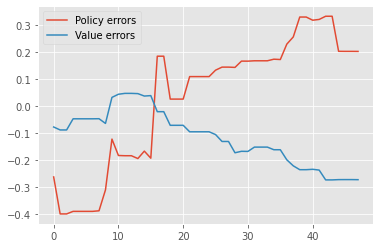

In [79]:
plt.plot(errors[:,0], label="Policy errors")
plt.plot(errors[:,1], label="Value errors")
plt.legend()
plt.show()